This project aims to classify 20newsgroup using bag-of-words model, and we represent each news as a vector of TfIdf values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

# 1.Fetch 20Newsgroup Data

In [2]:
#Fetch the news texts
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', 
                                  shuffle=True, random_state=11)
newsgroups_test = fetch_20newsgroups(subset='test', 
                                  shuffle=True, random_state=11)

In [3]:
print('Training text number:', len(newsgroups_train.data))
print('Testing text number:', len(newsgroups_test.data))

Training text number: 11314
Testing text number: 7532


In [4]:
#Take a lookt at the text
index = 0
label = newsgroups_train.target[index]
print("Type:",newsgroups_train.target_names[label])
print('#' * 20)
print("\n".join(newsgroups_train.data[index].split("\n")))

Type: comp.windows.x
####################
From: EEI.EEIIHY@memo.ericsson.SE (353-1-2800455)
Subject: help
Organization: The Internet
Lines: 5
NNTP-Posting-Host: enterpoop.mit.edu
To: XPERT@EXPO.LCS.MIT.EDU

--- Received from EEI.EEIIHY  353-1-2800455         93-04-26 12.28
  -> VAX.XPERT..EXPO.LCS.MIT.EDU..INET
  -: - - - - - - - - - - > MAIL USER IN VAX AND INTERNET
help




It seems there are a lot of punctuations within the texts, we can assume they play less important role in dertemining categories in this project. We only focus on words, terms, so we can remove those punctuations as well as digits.

# 2.Preprocessing

We are going to remove punctuations and digits.

In [5]:
#Remove extra blanks, punctuation, digits from original texts
import string
import re
def preProcessor(s):
    #s = s.encode('utf-8')

    #remove punctuation
    s = re.sub('['+string.punctuation+']', ' ', s)
    #remove digits
    s = re.sub('['+string.digits+']', ' ', s)
    #remove foreign characters
    s = re.sub('[^a-zA-Z]', ' ', s)
    #remove line ends
    s = re.sub('\n', ' ', s)
    #turn to lower case
    s = s.lower()
    #remove stopwords
    #for item in stopwords:
        #s = s.replace(item, ' ') 
    #remove extra blanks
    s = re.sub('[ ]+',' ', s)
    s = s.rstrip()

    #s = s.translate(string.punctuation)

    return s

Preprocess each piece of news.

In [6]:
newsgroups_train.data = [preProcessor(item).strip() for item in newsgroups_train.data]
newsgroups_test.data = [preProcessor(item).strip() for item in newsgroups_test.data]

Take a look at the preprocessed data.

In [7]:
preProcessor(newsgroups_train.data[0])

'from eei eeiihy memo ericsson se subject help organization the internet lines nntp posting host enterpoop mit edu to xpert expo lcs mit edu received from eei eeiihy vax xpert expo lcs mit edu inet mail user in vax and internet help'

In [9]:
import pandas as pd
train_data = pd.DataFrame({'text': newsgroups_train.data, 'target': newsgroups_train.target})
test_data = pd.DataFrame({'text': newsgroups_test.data, 'target': newsgroups_test.target})


In [10]:
train_data.to_csv('data/train_data.csv', index=False)
test_data.to_csv('data/test_data.csv', index=False)

# 3.Data Exploration

In [ ]:
#Calculate the character lengths for each piece of news
lengths =  [len(item) for item in newsgroups_train.data]
plt.style.use('ggplot')
plt.hist(lengths, bins=30)
plt.title('News Length Histogram')

Most news has a length of less than 5000 characters.

In [ ]:
word_counts = [len(item.split()) for item in newsgroups_train.data]
#Make a boxplot, ignore outliers
plt.boxplot(word_counts, sym='')
plt.title('Word Counts Boxplot')

In [ ]:
#Have a look at long sentences
for i, text in enumerate(newsgroups_train.data):
    if word_counts[i] > 1000:
        print(text)
        break

In [ ]:
#Make boxplots for each category
import pandas as pd
label_count_dict = {'Category':newsgroups_train.target,'WordNum': word_counts}
label_count_df = pd.DataFrame(label_count_dict)

In [ ]:
label_count_df.boxplot(column='WordNum', by='Category')

It seems each category has very long news with over 1000 words.

In [ ]:
np.percentile(word_counts, [25, 50, 90])

The majority of news has less than 600 words.

# 4.TfIdf Model

Bag-of-word model is commonly used in text classification, first we build a vocabulary and calculate the TfIdf values for each terms within each text, which can be used as input for classification algorithms.

## 4.1 Unigram TfIdf Model

In [8]:
#Build Vocabulary 
words = []
for text in newsgroups_train.data:
    words.extend(text.split())
len(words)

3554834

In [9]:
from collections import Counter
word_freq = Counter(words)
len(word_freq)

89038

In [10]:
#Select 50000 most frequent words
vocab_pair = word_freq.most_common(50000)
vocab_sorted = sorted(vocab_pair, key=lambda d:d[1], reverse = False)
vocab_sorted[:20]

[('eei', 2),
 ('eeiihy', 2),
 ('unconventianal', 2),
 ('hereditory', 2),
 ('feisal', 2),
 ('bronfman', 2),
 ('disolve', 2),
 ('sourcen', 2),
 ('segregated', 2),
 ('hoffa', 2),
 ('qvu', 2),
 ('peering', 2),
 ('uninterpreted', 2),
 ('predictor', 2),
 ('cmsr', 2),
 ('laud', 2),
 ('lafleur', 2),
 ('calders', 2),
 ('journeymen', 2),
 ('vacuous', 2)]

In [11]:
#Build Vocabulary for Unigrams
vocab = [item[0] for item in vocab_pair]
vocab_freq_dict = {item[0]:item[1] for item in vocab_pair}

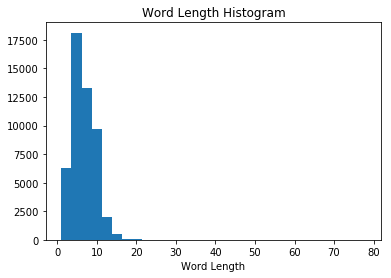

In [12]:
lengths = [len(item[0]) for item in vocab_sorted]
plt.hist(lengths, bins=30)
plt.title('Word Length Histogram')
plt.xlabel('Word Length')

Most words consist of letters less than 20, those very long words can be viewed as typos.

In [13]:
vocab_unigrams = [item[0] for item in vocab_sorted if len(item[0])<21]
#vocab_unigrams = [item[0] for item in vocab_sorted]

In [14]:
len(vocab_unigrams)

49971

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), vocabulary=vocab_unigrams)
X_train_tfidf = tfidfVectorizer.fit_transform(newsgroups_train.data)
X_train_tfidf.shape

(11314, 49971)

In [16]:
X_test_tfidf = tfidfVectorizer.transform(newsgroups_test.data)
X_test_tfidf.shape

(7532, 49971)

## 4.2 Classification Models

First, We can extract TfIdf values as features for each document.
### Naive Bayes

In [ ]:
import time
from sklearn.naive_bayes import MultinomialNB, GaussianNB
#Use naive bayesian
start = time.time()
clf_nb = MultinomialNB(0.1).fit(X_train_tfidf, newsgroups_train.target)

It is common to use micro F1 and macro F1 values as the metrics for document classification. For more details, please refer to http://firefenix.blog.163.com/blog/static/10338509720134973556756/.

In [139]:
#Test the model
predicted = clf_nb.predict(X_test_tfidf)
#Micro F1
from sklearn.metrics import f1_score
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='micro')))

Micro F1: 0.836


In [134]:
#Macro F1
print('Macro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='macro')))

Macro F1: 0.827


In [135]:
#F1 value for each category
#from sklearn.metrics import accuracy_score
class_scores = f1_score(newsgroups_test.target, predicted, average=None)

In [136]:
dict(zip(newsgroups_test.target_names, class_scores))

{'alt.atheism': 0.80000000000000004,
 'comp.graphics': 0.73630573248407649,
 'comp.os.ms-windows.misc': 0.70649350649350651,
 'comp.sys.ibm.pc.hardware': 0.70560747663551415,
 'comp.sys.mac.hardware': 0.83462532299741587,
 'comp.windows.x': 0.8058124174372524,
 'misc.forsale': 0.80683311432325888,
 'rec.autos': 0.90025575447570327,
 'rec.motorcycles': 0.9390243902439025,
 'rec.sport.baseball': 0.93851944792973652,
 'rec.sport.hockey': 0.96186961869618692,
 'sci.crypt': 0.91266912669126687,
 'sci.electronics': 0.77880794701986766,
 'sci.med': 0.8638743455497383,
 'sci.space': 0.89325153374233124,
 'soc.religion.christian': 0.85456595264937996,
 'talk.politics.guns': 0.82014388489208634,
 'talk.politics.mideast': 0.95594125500667559,
 'talk.politics.misc': 0.70881226053639845,
 'talk.religion.misc': 0.61538461538461542}

From the f1 scores above, it is clear that certain news such as politics, religion can be confused to large extent. For example, the category of talk.religion.misc is quite correlated with soc.religion.christian, even humans, it's not easy for us to distinguish them correctly.

In [137]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(newsgroups_test.target, predicted)

In [138]:
confusionMatrix

array([[248,   0,   0,   3,   0,   1,   0,   1,   1,   1,   0,   1,   0,
          6,   5,  36,   4,   3,   1,   8],
       [  1, 289,  19,  14,   7,  23,   5,   0,   0,   3,   2,   6,   9,
          0,   8,   1,   1,   1,   0,   0],
       [  1,  26, 272,  46,   4,  19,   3,   1,   3,   3,   1,   4,   1,
          1,   5,   2,   0,   0,   1,   1],
       [  0,   7,  25, 302,  21,   0,  12,   1,   0,   1,   0,   1,  19,
          0,   3,   0,   0,   0,   0,   0],
       [  0,   7,  11,  15, 323,   1,   7,   3,   1,   2,   0,   2,   9,
          1,   2,   0,   1,   0,   0,   0],
       [  1,  31,  25,  11,   8, 305,   1,   0,   2,   0,   0,   4,   1,
          1,   4,   1,   0,   0,   0,   0],
       [  0,   2,   6,  31,  11,   0, 307,  10,   6,   0,   2,   0,   9,
          4,   2,   0,   0,   0,   0,   0],
       [  0,   2,   2,   5,   1,   0,   9, 352,  10,   2,   2,   0,   4,
          1,   2,   0,   3,   0,   1,   0],
       [  0,   0,   0,   1,   0,   0,   5,   5, 385,   1,   0,  

### Lightgbm

Lightgbm is a new tool based on boosting methods, it is developed by Microsoft and claimed to be more powerful but memory efficient, for more information please visit: https://github.com/Microsoft/LightGBM/ .

In [57]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=111, reg_lambda=0.03, learning_rate=0.1, max_depth=10)
lgb_model.fit(X_train_tfidf, newsgroups_train.target)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=10, min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=10, n_jobs=-1,
        num_leaves=31, objective=None, random_state=111, reg_alpha=0.0,
        reg_lambda=0.03, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)

In [58]:
#Training score
ypred = lgb_model.predict(X_train_tfidf)
np.mean(ypred==newsgroups_train.target)

0.8310058334806435

In [59]:
#Testing score
ypred = lgb_model.predict(X_test_tfidf)
np.mean(ypred==newsgroups_test.target)

0.69583112055231011

### KNN算法

In [103]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=51,weights='distance')
knn.fit(X_train_tfidf, newsgroups_train.target)
predicted = knn.predict(X_test_tfidf)

In [104]:
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='micro')))

Micro F1: 0.720


In [111]:
target_doc_dict= {}
for i, target in enumerate(newsgroups_train.target):
    target_doc_dict[target] = target_doc_dict.get(target, [])
    target_doc_dict[target].append(X_train_tfidf[i].toarray())

In [119]:
#Calculate the center of each category
target_center_dict = {k: np.mean(v, axis=0) for k, v in target_doc_dict.items()}

In [125]:
#Label each news according to the distance between the news and category center
test_labels = []
for item in X_test_tfidf:
    vec1 = item.toarray()
    d = float("inf") 
    label = 0
    for k, v in target_center_dict.items():
        dist = np.linalg.norm(vec1 - v)  
        if d>dist:
            d = dist
            label = k
    test_labels.append(label) 

In [126]:
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, test_labels, average='micro')))

Micro F1: 0.749


### Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#clf_ad = AdaBoostClassifier(n_estimators=100, learning_rate=2).fit(X_train_tfidf, y_train)
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=4).fit(X_train_tfidf, newsgroups_train.target)

In [129]:
#Test the model
model = clf_rf
predicted = model.predict(X_test_tfidf)
#Micro F1
from sklearn.metrics import f1_score
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='micro')))

Micro F1: 0.774


### Neural Networks

Artificial neural networks has played an important role in machine learning which can make amazing results for models.

In [130]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-5, random_state=1,
                    learning_rate_init=.17)

In [131]:
clf_mlp = mlp.fit(X_train_tfidf, newsgroups_train.target)

Iteration 1, loss = 2.96118231
Iteration 2, loss = 2.77117550
Iteration 3, loss = 2.23234543
Iteration 4, loss = 1.47721032
Iteration 5, loss = 0.93207360
Iteration 6, loss = 0.61730430
Iteration 7, loss = 0.43358748
Iteration 8, loss = 0.32012814
Iteration 9, loss = 0.24245923
Iteration 10, loss = 0.18998902
Iteration 11, loss = 0.14912275
Iteration 12, loss = 0.12098446
Iteration 13, loss = 0.09900783
Iteration 14, loss = 0.08197751
Iteration 15, loss = 0.06934361
Iteration 16, loss = 0.05915446
Iteration 17, loss = 0.05147015
Iteration 18, loss = 0.04518071
Iteration 19, loss = 0.04024039
Iteration 20, loss = 0.03627635
Iteration 21, loss = 0.03279717
Iteration 22, loss = 0.02995513
Iteration 23, loss = 0.02759065
Iteration 24, loss = 0.02542908
Iteration 25, loss = 0.02379020
Iteration 26, loss = 0.02212853
Iteration 27, loss = 0.02079244
Iteration 28, loss = 0.01972725
Iteration 29, loss = 0.01859184
Iteration 30, loss = 0.01770685
Iteration 31, loss = 0.01679787
Iteration 32, los

In [132]:
predicted = clf_mlp.predict(X_test_tfidf)
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='micro')))

Micro F1: 0.845


In [37]:
mlp = MLPClassifier(hidden_layer_sizes=(150,), max_iter=300, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-5, random_state=1,
                    learning_rate_init=.07)

In [38]:
clf_mlp = mlp.fit(X_train_tfidf, newsgroups_train.target)

Iteration 1, loss = 2.98042550
Iteration 2, loss = 2.91911315
Iteration 3, loss = 2.82790789
Iteration 4, loss = 2.67766146
Iteration 5, loss = 2.43739406
Iteration 6, loss = 2.11078511
Iteration 7, loss = 1.75504134
Iteration 8, loss = 1.43329736
Iteration 9, loss = 1.17025175
Iteration 10, loss = 0.96039127
Iteration 11, loss = 0.79732357
Iteration 12, loss = 0.67033178
Iteration 13, loss = 0.56967223
Iteration 14, loss = 0.48976900
Iteration 15, loss = 0.42530563
Iteration 16, loss = 0.37233366
Iteration 17, loss = 0.32774214
Iteration 18, loss = 0.28971170
Iteration 19, loss = 0.25779439
Iteration 20, loss = 0.23104908
Iteration 21, loss = 0.20748241
Iteration 22, loss = 0.18731453
Iteration 23, loss = 0.16885350
Iteration 24, loss = 0.15344006
Iteration 25, loss = 0.13948357
Iteration 26, loss = 0.12726861
Iteration 27, loss = 0.11660577
Iteration 28, loss = 0.10697856
Iteration 29, loss = 0.09845698
Iteration 30, loss = 0.09136767
Iteration 31, loss = 0.08426247
Iteration 32, los

In [39]:
predicted = clf_mlp.predict(X_test_tfidf)
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='micro')))

Micro F1: 0.847


Perhaps with more iterations or more layers, the final result will be better.

In [43]:
mlp = MLPClassifier(hidden_layer_sizes=(150,), max_iter=300, alpha=2*1e-4,
                    solver='sgd', verbose=10, tol=1e-5, random_state=1,
                    learning_rate_init=.07)

In [44]:
clf_mlp = mlp.fit(X_train_tfidf, newsgroups_train.target)

Iteration 1, loss = 2.98051017
Iteration 2, loss = 2.91920273
Iteration 3, loss = 2.82800947
Iteration 4, loss = 2.67779351
Iteration 5, loss = 2.43758933
Iteration 6, loss = 2.11105438
Iteration 7, loss = 1.75537671
Iteration 8, loss = 1.43368531
Iteration 9, loss = 1.17068011
Iteration 10, loss = 0.96085181
Iteration 11, loss = 0.79781279
Iteration 12, loss = 0.67084408
Iteration 13, loss = 0.57020741
Iteration 14, loss = 0.49032584
Iteration 15, loss = 0.42588356
Iteration 16, loss = 0.37293121
Iteration 17, loss = 0.32835786
Iteration 18, loss = 0.29034456
Iteration 19, loss = 0.25844450
Iteration 20, loss = 0.23171556
Iteration 21, loss = 0.20816318
Iteration 22, loss = 0.18801003
Iteration 23, loss = 0.16956159
Iteration 24, loss = 0.15416051
Iteration 25, loss = 0.14021592
Iteration 26, loss = 0.12801179
Iteration 27, loss = 0.11736068
Iteration 28, loss = 0.10774199
Iteration 29, loss = 0.09923066
Iteration 30, loss = 0.09215062
Iteration 31, loss = 0.08505329
Iteration 32, los

In [46]:
predicted = clf_mlp.predict(X_test_tfidf)
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='micro')))

Micro F1: 0.847


## 4.3 Bigram TfIdf Model

In [139]:
#from sklearn.feature_extraction.text import  TfidfVectorizer
#Obtain tf-idf vector for each article
#remove stopwords in Enlgish
tfidfVectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 2), min_df=2, max_features=50000)
X_train_tfidf = tfidfVectorizer.fit_transform(newsgroups_train.data)
X_train_tfidf.shape

(11314, 50000)

In [140]:
X_test_tfidf = tfidfVectorizer.transform(newsgroups_test.data)
X_test_tfidf.shape

(7532, 50000)

In [141]:
news_words = tfidfVectorizer.get_feature_names()
news_words[:20]

['aa freenet',
 'aa fri',
 'aa inet',
 'aa insane',
 'aa mon',
 'aa organization',
 'aa thu',
 'aa tue',
 'aa wed',
 'aaa uoregon',
 'aamir hafeez',
 'aamir qazi',
 'aamrl wpafb',
 'aardvark ucs',
 'aargh great',
 'aario measure',
 'aario sami',
 'aaron arc',
 'aaron barnes',
 'aaron binah']

In [142]:
clf_nb = MultinomialNB(0.01).fit(X_train_tfidf, newsgroups_train.target)

In [143]:
#Test the model
predicted = clf_nb.predict(X_test_tfidf)
#Micro F1
from sklearn.metrics import f1_score
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.target, predicted, average='micro')))

Micro F1: 0.716


The bigram model is not so good.
**Generally, the predicted results were not so satisfying, Stanford gave explanations: "This is probably because in the bydate version of 20 Newsgroups, the test set is all from a later time period than the training set, whereas, when we subdivided the training set, we took a roughly uniform sample across it as the devtest set. Topics under discussion shift over time".** As we kept all the sample items in, it was likely that the test samples were somehow different from training samples. But at least, the final result was better the some of the work listed in https://nlp.stanford.edu/wiki/Software/Classifier/20_Newsgroups.

In order to make comparisons with latest works, we need to adopt proper data sets.

# 5.All-In-One Model

According to the analysis above, we are going to create a class to finish all the steps.

In [7]:
#Filter out those very long or very short news
train_data = []
train_label = []
test_data = []
test_label = []
for i, news in enumerate(newsgroups_train.data):
    news_len = len(news.split()) 
    if news_len > 5 and news_len < 400:
        train_data.append(news)
        train_label.append(newsgroups_train.target[i])
for i, news in enumerate(newsgroups_test.data):
    news_len = len(news.split()) 
    if news_len > 5 and news_len < 400:
        test_data.append(news)
        test_label.append(newsgroups_test.target[i])

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
#from stemming.porter2 import stem
from nltk.stem import WordNetLemmatizer
punctuations = string.punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from spacy.en import English
parser = English()

In [10]:
from sklearn.decomposition import PCA
class text_classification(object):
    '''This class aims to transform preprocessed texts into TfIdf vectors
    and applies specified models to do classifications'''
    def __init__(self, train_data, train_label, ngram=1, max_features=10000):
        '''Initialize Parameters'''
        self.train_data = train_data
        self.train_label = train_label
        self.ngram = ngram
        self.max_features = max_features
        self.vectorizer = self.__build_vectorizer()
        self.model = None
        
    def __spacy_tokenizer(self, sentence):
        #Remove punctuations and stops words, then lemmatize the words
        tokens = parser(sentence)
        tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
        tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]    
        sent = ' '.join(tokens)
        return sent
        
    def __lem_stem(self, data):
        '''Take lemmatizer and stemmize into account'''
        lemmatizer = WordNetLemmatizer()
        lem_data = [lemmatizer.lemmatize(word.strip()) for word 
                    in data.split()]
        data = ' '.join(lem_data)
        #stem_data = [stem(word.strip()) for word 
                    #in data.split() ]
        #data = ' '.join(data)
        return data
    
    def __dimension_reduction(self, data):
        '''Reduce dimension of original data'''
        threshold = 0.9
        pca = PCA()
        pca.fit(data)
        cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
        #Select a few principal compoents whose variances accounted for 90%
        n_component = sum(cumsum_variance > threshold)
        
        
    def __build_vectorizer(self):
        '''Build vectorized based on TfIdf model'''
        #self.train_data = [self.__spacy_tokenizer(news) for news in self.train_data]
        self.train_data = [self.__lem_stem(news) for news in self.train_data]
        tfidfVectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, self.ngram), 
                                          max_features=self.max_features)
        tfidfVectorizer.fit(self.train_data)
        return tfidfVectorizer
        
    def __text_transform(self, data):
        '''Transform each text into a vector of TfIdf values of terms'''
        if data is None:
            raise ValueError('Data Is Empty!')
        tfidfVectorizer = self.vectorizer
        text_tfidf = tfidfVectorizer.transform(data)
        return text_tfidf
    
    def train(self, model, validation=False):
        '''Train a model'''
        if model is None:
            raise ValueError('Model Must Be Specified!')
        train_tfidf = self.__text_transform(self.train_data)
        #Validate the performance of Classification Method
        if validation:
            scores = cross_val_score(model, train_tfidf, self.train_label, cv=5)
            print('Accuracy:', scores)
        model.fit(train_tfidf, self.train_label)
        self.model = model
        return model
    
    def test(self, test_data, test_label):
        '''Test the model after the model as been trained'''
        if self.model is None:
            raise ValueError('Model Must Be Specified!')
        test_data = [self.__lem_stem(news) for news in test_data]
        #test_data = [self.__spacy_tokenizer(news) for news in test_data]
        test_tfidf = self.__text_transform(test_data)
        preds = self.model.predict(test_tfidf)
        micro_f1 = f1_score(test_label, preds, average='micro')
        print('Micro F1: {:.3f}'.format(micro_f1))
        return micro_f1

In [11]:
#Create a model
#tc = text_classification(train_data, train_label, ngram=1, max_features=30000)
tc = text_classification(newsgroups_train.data, newsgroups_train.target, ngram=1, max_features=30000)

In [13]:
#Specify a classification model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=1e-4,
                    solver='sgd', verbose=False, tol=1e-5, random_state=1,
                    learning_rate_init=.17)
nb = MultinomialNB(0.01)
lr = LogisticRegression(C=0.5)
rf =  RandomForestClassifier(n_estimators=100, n_jobs=4)

In [14]:
tc.train(nb)
tc.test(newsgroups_test.data, newsgroups_test.target)
#tc.test(test_data, test_label)

Micro F1: 0.826


0.82594264471587908

### Train Different Models

In [173]:
#Train the model with several classifiers
models = [lr, rf, nb, mlp]
for model in models:
    print(model.__class__)
    validation = True
    if model is mlp:
        validation = False
    tc.train(model, validation)
    tc.test(newsgroups_test.data, newsgroups_test.target)
    print('*'*30)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy: [ 0.87659762  0.88570168  0.88030035  0.87964602  0.87538803]
Micro F1: 0.819
******************************
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Accuracy: [ 0.84045835  0.84686673  0.85689046  0.84646018  0.83725055]
Micro F1: 0.779
******************************
<class 'sklearn.naive_bayes.MultinomialNB'>
Accuracy: [ 0.90832966  0.90997352  0.90415194  0.90973451  0.91929047]
Micro F1: 0.830
******************************
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Micro F1: 0.844
******************************


### Tune Parameters

We can select naive bayesian classifier as the final model, and with gridsearch we can figure out which 'alpha' can optimize the performance of the model on testing data set.

In [52]:
from sklearn.model_selection import GridSearchCV 
parameters = {'alpha': [2, 1, 0.5, 0.2, 0.1, 0.05]}
nb = MultinomialNB(0.01)
gs = GridSearchCV(estimator=nb, param_grid=parameters, cv=5)
tc.train(gs)
tc.test(newsgroups_test.data, newsgroups_test.target)

Micro F1: 0.830


0.83019118428040362

In [60]:
import pandas as pd
df_result = pd.DataFrame(gs.cv_results_)

In [61]:
df_result

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.075126,0.010104,0.869454,0.934020,2,{'alpha': 2},6,0.865580,0.934107,0.876434,...,0.868375,0.933812,0.869027,0.933841,0.867849,0.934982,0.006495,0.000583,0.003681,0.000538
1,0.072024,0.010204,0.882535,0.952028,1,{'alpha': 1},5,0.881005,0.951797,0.887467,...,0.882509,0.951713,0.881858,0.951292,0.879823,0.952865,0.002409,0.000679,0.002627,0.000565
2,0.070223,0.009804,0.892523,0.965662,0.5,{'alpha': 0.5},4,0.888497,0.965395,0.895852,...,0.893110,0.965304,0.895575,0.965651,0.889579,0.966442,0.000400,0.000400,0.003021,0.000407
3,0.070324,0.011404,0.900389,0.980643,0.2,{'alpha': 0.2},3,0.899074,0.979989,0.899382,...,0.900618,0.980331,0.902655,0.980892,0.900222,0.981455,0.000400,0.002801,0.001261,0.000501
4,0.070123,0.009904,0.905780,0.986587,0.1,{'alpha': 0.1},2,0.906126,0.986512,0.904237,...,0.904594,0.986409,0.906195,0.986636,0.907761,0.987195,0.001020,0.000200,0.001264,0.000338
5,0.071324,0.010104,0.907195,0.990741,0.05,{'alpha': 0.05},1,0.907007,0.990934,0.906443,...,0.905035,0.990718,0.907080,0.991164,0.910421,0.991169,0.001601,0.000490,0.001769,0.000537


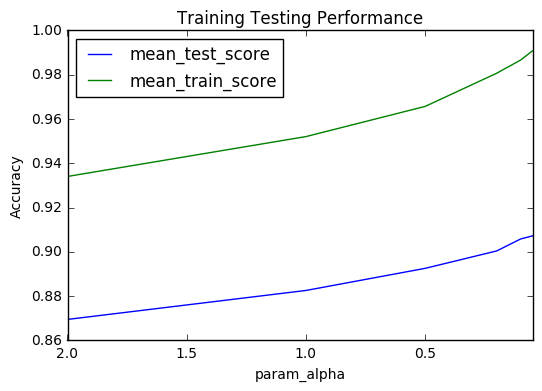

In [65]:
df_result.set_index('param_alpha')[['mean_test_score', 'mean_train_score']].plot()
plt.ylabel('Accuracy')
plt.title('Training Testing Performance')

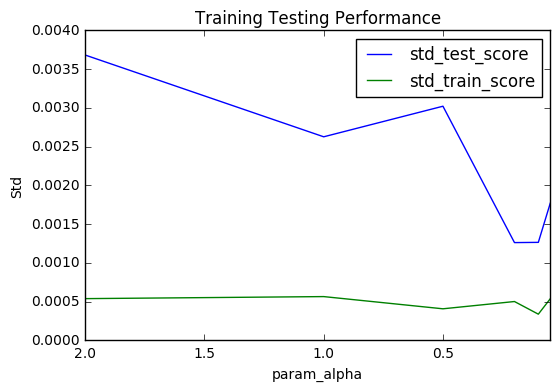

In [66]:
df_result.set_index('param_alpha')[['std_test_score', 'std_train_score']].plot()
plt.ylabel('Std')
plt.title('Training Testing Performance')